## **Setup**

##### install wandb

In [ ]:
!pip install wandb   # run this command to insatll wandb on colab - worth it!

##### setup

In [1]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

# import wandb
# from wandb.keras import WandbCallback

from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from tensorflow.keras.applications import ResNet50, VGG19, VGG16, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [2]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


In [3]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**



### Loading python scripts

All functions will be used in the "Training the Model" section.

In [4]:
# paths for the datasets
experiment_auxiliary_path = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
synthetic_auxiliary_path = 'MAFAT RADAR Challenge - Auxiliary Synthetic Set V2'
train_path = 'MAFAT RADAR Challenge - Training Set V1'
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'

In [5]:
files_path = mount_path + "My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar"
sys.path.append(files_path)

In [6]:
from loading_functions import load_data, load_pkl_data, load_csv_metadata, load_data_all_datasets, append_dict
from spectogram_plots import plot_shited_spectrogram, plot_recenter_midline_spectrogram, spectrogram_cmap
from model_roc_function import stats
from data_augmentation import  recenter_midline, shift_spectrogram
from data_preprocessing_funcs import data_preprocess
from plot_learning_curve import plot_loss_and_accuracy_over_epoches
from data_augmentation import recenter_midline, shift_spectrogram
from full_loading_and_process import process_and_split_data
from sampling_data import subsampling, subsampling_segments_target_ratio, balance_target, split_x_y, split_train_val


np.save('/content/cmap.npy', spectrogram_cmap)

### model configurations - dict

In [7]:
model_input = {
                'data_extraction':  {
                                    'train_df': [4, False],  # [num segments in track, balance the data?]
                                    'valid_df': [4, True],
                                    'exp_df':   [2, False],
                                    'synth_df': [1, True]
                                    },
                'model_conf' : {
                              'sota_model': "ResNet50",
                              'sota_model_layer': "conv4_block1_2_conv",
                              'input_last_channel': 3,
                              'batch_norm': False,
                              'batch_size':64,
                              'no_epochs':100,
                              'learning_rate': 0.0005,
                              'monitor': 'val_accuracy'
                              },
               'callback' : {'early_stop':{
                                           'patience':10,
                                           'verbose': 1
                                          },
                            'model_checkpoint':{
                                                'flag':True,
                                                'file_path':f"{mount_path}My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models",
                                                'save_weights_only':False,
                                                'verbose': 1
                                                }
                            },
               'IDG' : {
                        'vertical_flip':True,
                        'horizontal_flip':True,
                        'width_shift_range' : 0,
                        'height_shift_range': 0,
                        'fill_mode':'nearest',
                        'brightness_range' : [1,1],
                        'preprocessing_function' : None
                        }        
                }

### **Splitting the Training set**



The functions below split the training set into Train and Validation sets.

the logic: 

- take the full training set and split it to train and validation according to track id and make sure to that there are no segments of the same track in the training and in the validation (similar to the approach of MAFAT)
- To do the split in the easiest way, we will take still only geolocations 1 and 4 but this time the sampling of the segments will use the subsampling function

- to the x_train we will add data from the expeirment and from the synthetic datasets, using sampling- making sure the the number will lead to balanced data between animal and humans in the end  

In [ ]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset

# function is part of the python scripts

## **Model functions**

### **CNN Model** - transfer learning


In [ ]:
# Building the model
def create_model(model_tl, init, layer, input_shape= (126, 32, 3)):
  """
  Transfer learning Resnet model. trained on imagenet
  The input shape must be RGB, hense we must duplicate the channel 3 times

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model - with resnet inside  
  """


  transfer_learning_model = model_tl(include_top=False, weights="imagenet", pooling='avg')

  model_num_wandb = wandb.run.name.rsplit("-")[-1]

  tl_model = Sequential(name=f"{transfer_learning_model.name}_{model_num_wandb}")

  tl_model.add(Input(shape=input_shape))

  if input_shape[-1] == 1:
    tl_model.add(Conv2D(3,(3,3),padding='same'))
  
  tl_model.add(Model(inputs=transfer_learning_model.input, outputs=transfer_learning_model.get_layer(layer).output, name=transfer_learning_model.name))

  if model_input['model_conf']['batch_norm']:
    tl_model.add(BatchNormalization())

  tl_model.add(Flatten())

  # tl_model.add(Dense(64, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  # tl_model.add(Dropout(0.3))

  # tl_model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  # tl_model.add(Dropout(0.15))
  tl_model.add(Dense(1, activation='sigmoid', kernel_initializer = init))

  # Say not to train first layer of the model. It is already trained
  tl_model.layers[0].trainable = False


  return tl_model

#### Baseline model of MAFAT

In [ ]:
# Building the model
def create_model_cnn_baseline(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model

## Loading the data


#### loading the data and pre-processing

In [8]:
def load_and_split_data():
  training_df, synthetic_auxiliary_df, experiment_auxiliary_df = load_data_all_datasets()
  train_x, val_x, test_x, train_y, val_y, test_df  = process_and_split_data(training_df, synthetic_auxiliary_df, experiment_auxiliary_df, model_input['data_extraction'])
  del training_df, synthetic_auxiliary_df, experiment_auxiliary_df
  return train_x, val_x, test_x, train_y, val_y, test_df

In [9]:
train_x, val_x, test_x, train_y, val_y, test_df  = load_and_split_data()

if model_input['model_conf']['input_last_channel'] == 1:
  print("using conv2d - one channel input")
  train_x = train_x[:, :, :, 1]
  train_x = train_x.reshape(list(train_x.shape)+[1])

  val_x = val_x[:, :, :, 1]
  val_x = val_x.reshape(list(val_x.shape)+[1])

  test_x = test_x[:, :, :, 1]
  test_x = test_x.reshape(list(test_x.shape)+[1])

train_x.shape, val_x.shape, test_x.shape

[INFO] Loading and spliting the data
[INFO] Loading Auxiliary Experiment set - can take a few minutes
[INFO] Loading Auxiliary Synthetic set - can take a few minutes
[INFO] Loading Train set - can take a few minutes
exp_df 2 False
synt_df 1 True
train_df 4 False
valid_df 4 True
exp_df humans segments: 5215 0
synt_df humans segments: 447 447
train_df humans segments: 0 2995
valid_df humans segments: 399 399
[INFO] Adding segments from the experiment and Synthetic auxiliary sets to the training set
[INFO] Preprocessing and split the data to training and validation
[INFO] Creating 3 channels for the train and validation set
[INFO] Loading and preprocessing public test set


((9104, 126, 32, 3), (798, 126, 32, 3), (106, 126, 32, 3))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


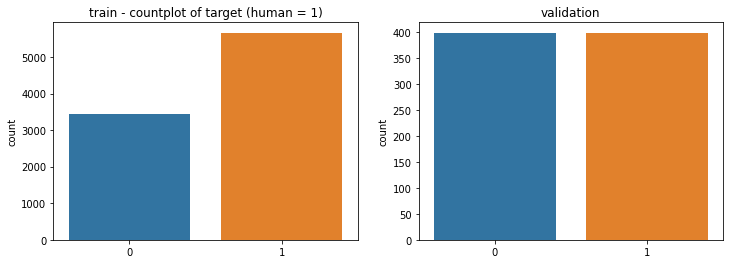

In [10]:
fig, ax =plt.subplots(1,2, figsize=(12,4))
sns.countplot(train_y, ax=ax[0])
sns.countplot(val_y, ax=ax[1])

ax[0].set_title("train - countplot of target (human = 1)")
ax[1].set_title("validation");

## **Training The Model functions**

#### ImageDataGenerator + model callbacks + Wandb config

In [ ]:
def create_IDG(idg_input,train_x):
  datagen = ImageDataGenerator(
                                vertical_flip = idg_input['vertical_flip'],
                                horizontal_flip=idg_input['horizontal_flip'],
                                width_shift_range = idg_input['width_shift_range'],
                                height_shift_range=idg_input['height_shift_range'],
                                fill_mode=idg_input['fill_mode'],
                                brightness_range = idg_input['brightness_range'],
                                preprocessing_function = idg_input['preprocessing_function']
                              )
  #Fitting the Image Generator defined above to the X train data set
  datagen.fit(train_x)

  return datagen

In [ ]:
def callbacks(model, final_model_path):
     
    mc = tf.keras.callbacks.ModelCheckpoint(final_model_path,
                                            monitor= model_input['model_conf']['monitor'],
                                            verbose= model_input['callback']['model_checkpoint']['verbose'],
                                            save_best_only=True,
                                            save_weights_only=False,
                                            ) 
    earlystop = EarlyStopping(patience= model_input['callback']['early_stop']['patience'], 
                              monitor = model_input['model_conf']['monitor'],
                              verbose = model_input['callback']['early_stop']['verbose'])
    return mc, earlystop

### wandb connfig and build model

In [ ]:
def wandb_config():

  wandb.init(project="MAFAT",
            config={
                'sota_model':        model_input['model_conf']["sota_model"],
                'sota_model_layer':  model_input['model_conf']["sota_model_layer"],
                'input_last_channel':model_input['model_conf']['input_last_channel'],
                "batch_size":        model_input['model_conf']["batch_size"],
                "no_epochs":         model_input['model_conf']["no_epochs"],
                "learning_rate":     model_input['model_conf']["learning_rate"],
                "data_extraction":   model_input["data_extraction"],
                'batch_norm':        model_input['model_conf']['batch_norm']
            })

In [ ]:
def build_model():
  """
  buliding the model according to the config dict
  important to chose sota_model, sota_model_layer, input_last_channel
  """
  img_width, img_height = 126, 32
  loss_function = BinaryCrossentropy()
  optimizer = Adam(learning_rate = wandb.config.learning_rate)
  init = tf.keras.initializers.GlorotNormal(seed = 0)
  input_shape = (img_width, img_height, wandb.config.input_last_channel)  # must be 3 is RGB for using transfer learning

  if wandb.config.sota_model == "ResNet50":
    tl_model_build = ResNet50
  elif wandb.config.sota_model == "VGG19":
    tl_model_build = VGG19

  elif wandb.config.sota_model == "VGG16":
    tl_model_build = VGG16
  elif wandb.config.sota_model == "Xception":
    tl_model_build = Xception
  
  else:
    print("No existing model has been chosen")
  
  model = create_model(tl_model_build, init, wandb.config.sota_model_layer, input_shape)  
  model.compile(loss=loss_function, optimizer=optimizer, metrics=['AUC', 'accuracy'])

  folder_models_path = model_input['callback']['model_checkpoint']['file_path']

  final_model_path = f'{folder_models_path}/{model.name}.h5'
  mc, earlystop = callbacks(model, final_model_path) 


  return model, mc, earlystop, final_model_path


### run single model, run several layers and plot results

In [ ]:
def run_model(model, mc, earlystop):

  datagen = create_IDG(model_input['IDG'], train_x)
  flow = datagen.flow(train_x, train_y, batch_size=wandb.config.batch_size)
  
  history = model.fit(flow,
                      steps_per_epoch=len(train_x) // wandb.config.batch_size,
                      epochs=wandb.config.no_epochs,
                      validation_data=(val_x, val_y),
                      validation_steps=len(val_x) // wandb.config.batch_size,
                      callbacks=[mc, earlystop, WandbCallback(data_type="image", validation_data=(val_x, val_y))])
  return history

In [ ]:
def plot_roc_curve_of_models(final_model_path):

  print(f"model: {final_model_path.rsplit('/')[-1]}")
  final_model = tf.keras.models.load_model(final_model_path)
  # Plot ROC curve and show ROC-AUC results of the training and validation sets. 
  pred = [final_model.predict(train_x), final_model.predict(val_x)]
  actual = [train_y, val_y]
  stats(pred, actual)

In [ ]:
def run_several_layers(model_name, layers_list):
  print(f"checkin model: {model_name}")
  for i, output_layer in enumerate(layers_list):
    print(f"layer {i + 1} - {output_layer} - out of {len(layers_list)}")
    
    model_input['model_conf']['sota_model'] = model_name
    model_input['model_conf']['sota_model_layer'] = output_layer

    wandb_config()
    model, mc, earlystop, final_model_path = build_model()
    history = run_model(model, mc, earlystop)

## Models

### Resnet50

In [ ]:
model_input['model_conf']['sota_model'] = "ResNet50"
model_input['model_conf']['sota_model_layer'] = "conv4_block1_2_conv"


# Creating and running the model
wandb_config()
model, mc, earlystop, final_model_path = build_model()
model.summary()

wandb: Waiting for W&B process to finish, PID 7885
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_130010-1pqr05d2/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_130010-1pqr05d2/logs/debug-internal.log
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: 
wandb: Synced devoted-galaxy-70: https://wandb.ai/inbar_sh/MAFAT/runs/1pqr05d2
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200925_130225-3gntvsf9
wandb: Syncing run resilient-snowflake-71



Model: "resnet50_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 256)   2182528   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4097      
Total params: 2,186,625
Trainable params: 4,097
Non-trainable params: 2,182,528
_________________________________________________________________


#### running the model

In [ ]:
history_resnet50 = run_model(model, mc, earlystop)

Epoch 1/50
242/243 [============================>.] - ETA: 0s - loss: 0.1714 - auc: 0.9808 - accuracy: 0.9365
Epoch 00001: val_accuracy improved from -inf to 0.51121, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/resnet50_56.h5
243/243 [==============================] - 9s 36ms/step - loss: 0.1711 - auc: 0.9809 - accuracy: 0.9365 - val_loss: 0.8545 - val_auc: 0.7523 - val_accuracy: 0.5112
Epoch 2/50
241/243 [============================>.] - ETA: 0s - loss: 0.1109 - auc: 0.9908 - accuracy: 0.9597
Epoch 00002: val_accuracy improved from 0.51121 to 0.69731, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/resnet50_56.h5
243/243 [==============================] - 7s 29ms/step - loss: 0.1109 - auc: 0.9908 - accuracy: 0.9595 - val_loss: 0.6063 - val_auc: 0.7445 - val_accuracy: 0.6973
Epoch 3/50
243/243 [==============================] - ETA: 0s - loss: 0.0993 - auc: 0.9925 - accuracy: 0.9639
Epoch

#### running a loop over several layers

In [ ]:
resnent50 = ResNet50(include_top=False, weights="imagenet", pooling='avg')
resnent50_last_layers = [layer.name for layer in resnent50.layers[-10:]]
resnent50_last_layers

In [ ]:
run_several_layers("ResNet50", resnent50_last_layers[:1])

In [ ]:
for i, output_layer in enumerate(resnent50_last_layers):
  print(f"layer {i} - {output_layer} - out of {len(resnent50_last_layers)}")
  if output_layer.startswith("conv"):
    model_input['model_conf']['sota_model'] = "ResNet50"
    model_input['model_conf']['sota_model_layer'] = output_layer

    wandb_config()
    model, mc, earlystop, final_model_path = build_model()
    history_resnet50 = run_model(model, mc, earlystop)

wandb: Waiting for W&B process to finish, PID 3067
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_122749-1a8wr4jk/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_122749-1a8wr4jk/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 4
wandb:            loss 0.09535645693540573
wandb:             auc 0.9930832982063293
wandb:        accuracy 0.9651792645454407
wandb:        val_loss 1.3968284130096436
wandb:         val_auc 0.5529268383979797
wandb:    val_accuracy 0.5
wandb:           _step 4
wandb:        _runtime 81
wandb:      _timestamp 1601036953
wandb:   best_val_loss 1.0319820642471313
wandb:      best_epoch 1
wandb: Run history:
wandb:          epoch ▁▃▅▆█
wandb:           loss █▃▂▁▁
wandb:            auc ▁▆▇██
wandb:       accuracy ▁▆▇██
wandb:       val_loss ▃▁▄▃█
wandb:        val_auc █▅▃▃▁
wandb:   val_accuracy █▁█▁█
wandb:          _step ▁▃▅▆█
wandb:       _runtime ▁▃▅▆█
wandb:     _tim


Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 0.1776 - auc: 0.9803 - accuracy: 0.9360
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_60.h5
243/243 [==============================] - 15s 61ms/step - loss: 0.1776 - auc: 0.9803 - accuracy: 0.9360 - val_loss: 1.2230 - val_auc: 0.6229 - val_accuracy: 0.5000
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.1137 - auc: 0.9904 - accuracy: 0.9574
Epoch 00002: val_accuracy did not improve from 0.50000
243/243 [==============================] - 13s 53ms/step - loss: 0.1137 - auc: 0.9904 - accuracy: 0.9574 - val_loss: 1.0721 - val_auc: 0.5950 - val_accuracy: 0.5000
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.1082 - auc: 0.9910 - accuracy: 0.9596
Epoch 00003: val_accuracy did not improve from 0.50000
243/243 [==============================] - 

wandb: Waiting for W&B process to finish, PID 3366


Epoch 00005: early stopping



wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_122941-18m96fs1/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_122941-18m96fs1/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 4
wandb:            loss 0.0984148383140564
wandb:             auc 0.992485761642456
wandb:        accuracy 0.9631158113479614
wandb:        val_loss 1.236600637435913
wandb:         val_auc 0.5789177417755127
wandb:    val_accuracy 0.49775785207748413
wandb:           _step 4
wandb:        _runtime 72
wandb:      _timestamp 1601037060
wandb:   best_val_loss 1.0721052885055542
wandb:      best_epoch 1
wandb: Run history:
wandb:          epoch ▁▃▅▆█
wandb:           loss █▂▂▂▁
wandb:            auc ▁▇▇██
wandb:       accuracy ▁▇▇▇█
wandb:       val_loss ▅▁▄█▅
wandb:        val_auc █▄▃▁▂
wandb:   val_accuracy ████▁
wandb:          _step ▁


Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 0.2602 - auc: 0.9753 - accuracy: 0.9158
Epoch 00001: val_accuracy improved from -inf to 0.52466, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_61.h5
243/243 [==============================] - 15s 61ms/step - loss: 0.2602 - auc: 0.9753 - accuracy: 0.9158 - val_loss: 0.7049 - val_auc: 0.6521 - val_accuracy: 0.5247
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.1459 - auc: 0.9884 - accuracy: 0.9527
Epoch 00002: val_accuracy did not improve from 0.52466
243/243 [==============================] - 12s 48ms/step - loss: 0.1459 - auc: 0.9884 - accuracy: 0.9527 - val_loss: 0.8174 - val_auc: 0.6410 - val_accuracy: 0.5000
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.1252 - auc: 0.9901 - accuracy: 0.9569
Epoch 00003: val_accuracy did not improve from 0.52466
243/243 [==============================] - 

wandb: Waiting for W&B process to finish, PID 3642
wandb: Program ended successfully.


Epoch 00005: early stopping



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_123100-36ku1ktq/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_123100-36ku1ktq/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 4
wandb:            loss 0.1089765802025795
wandb:             auc 0.9921473264694214
wandb:        accuracy 0.9616971611976624
wandb:        val_loss 1.0657312870025635
wandb:         val_auc 0.6190049648284912
wandb:    val_accuracy 0.5022421479225159
wandb:           _step 4
wandb:        _runtime 71
wandb:      _timestamp 1601037137
wandb:   best_val_loss 0.7048797607421875
wandb:      best_epoch 0
wandb: Run history:
wandb:          epoch ▁▃▅▆█
wandb:           loss █▃▂▁▁
wandb:            auc ▁▆▇██
wandb:       accuracy ▁▇▇██
wandb:       val_loss ▁▃▅▆█
wandb:        val_auc █▆▄▂▁
wandb:   val_accuracy █▁▂▂▂
wandb:          _step ▁▃▅▆█
wandb:       _runtime ▁▃▅▆█
w


Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 0.3143 - auc: 0.9634 - accuracy: 0.8933
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_62.h5
243/243 [==============================] - 15s 63ms/step - loss: 0.3143 - auc: 0.9634 - accuracy: 0.8933 - val_loss: 0.7367 - val_auc: 0.5881 - val_accuracy: 0.5000
Epoch 2/100
242/243 [============================>.] - ETA: 0s - loss: 0.1819 - auc: 0.9832 - accuracy: 0.9420
Epoch 00002: val_accuracy improved from 0.50000 to 0.58072, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_62.h5
243/243 [==============================] - 13s 55ms/step - loss: 0.1817 - auc: 0.9833 - accuracy: 0.9421 - val_loss: 0.6756 - val_auc: 0.6034 - val_accuracy: 0.5807
Epoch 3/100
242/243 [============================>.] - ETA: 0s - loss: 0.1584 

wandb: Waiting for W&B process to finish, PID 3923
wandb: Program ended successfully.


Epoch 00011: early stopping



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_123217-7txmsi14/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_123217-7txmsi14/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 10
wandb:            loss 0.11796552687883377
wandb:             auc 0.9900861382484436
wandb:        accuracy 0.9569254517555237
wandb:        val_loss 1.1488372087478638
wandb:         val_auc 0.6355345845222473
wandb:    val_accuracy 0.49775785207748413
wandb:           _step 10
wandb:        _runtime 151
wandb:      _timestamp 1601037293
wandb:   best_val_loss 0.6631854772567749
wandb:      best_epoch 5
wandb: Run history:
wandb:          epoch ▁▂▂▃▄▅▅▆▇▇█
wandb:           loss █▃▂▂▂▁▁▁▁▁▁
wandb:            auc ▁▆▇▇▇██████
wandb:       accuracy ▁▆▆▇▇██████
wandb:       val_loss ▂▁▂▁▁▁▁▅▂▄█
wandb:        val_auc ▁▃▃▇▇██▇▇▇▇
wandb:   val_accuracy ▁▆▃▂▇▇█▁▅▂▁
wandb:    


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 0.2131 - auc: 0.9750 - accuracy: 0.9236
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_63.h5
243/243 [==============================] - 15s 64ms/step - loss: 0.2130 - auc: 0.9750 - accuracy: 0.9237 - val_loss: 1.0824 - val_auc: 0.5509 - val_accuracy: 0.5000
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.1352 - auc: 0.9876 - accuracy: 0.9505
Epoch 00002: val_accuracy did not improve from 0.50000
243/243 [==============================] - 12s 50ms/step - loss: 0.1352 - auc: 0.9876 - accuracy: 0.9505 - val_loss: 1.5655 - val_auc: 0.5796 - val_accuracy: 0.5000
Epoch 3/100
242/243 [============================>.] - ETA: 0s - loss: 0.1214 - auc: 0.9897 - accuracy: 0.9555
Epoch 00003: val_accuracy did not improve from 0.50000
243/243 [==============================] - 

wandb: Waiting for W&B process to finish, PID 4504
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_123453-31pit1iy/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_123453-31pit1iy/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 4
wandb:            loss 0.1162404790520668
wandb:             auc 0.9899508357048035
wandb:        accuracy 0.9606654644012451
wandb:        val_loss 2.1340157985687256
wandb:         val_auc 0.6050493717193604
wandb:    val_accuracy 0.5
wandb:           _step 4
wandb:        _runtime 73
wandb:      _timestamp 1601037374
wandb:   best_val_loss 1.0823720693588257
wandb:      best_epoch 0
wandb: Run history:
wandb:          epoch ▁▃▅▆█
wandb:           loss █▂▁▁▁
wandb:            auc ▁▇███
wandb:       accuracy ▁▆▇▇█
wandb:       val_loss ▁▄▇██
wandb:        val_auc ▁▅▄██
wandb:   val_accuracy ▁▁▁▁▁
wandb:          _step ▁▃▅▆█
wandb:       _runtime ▁▃▅▆█
wandb:     _time


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 0.3247 - auc: 0.9587 - accuracy: 0.8815
Epoch 00001: val_accuracy improved from -inf to 0.58744, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_64.h5
243/243 [==============================] - 15s 64ms/step - loss: 0.3242 - auc: 0.9588 - accuracy: 0.8819 - val_loss: 0.6760 - val_auc: 0.6182 - val_accuracy: 0.5874
Epoch 2/100
242/243 [============================>.] - ETA: 0s - loss: 0.1792 - auc: 0.9847 - accuracy: 0.9430
Epoch 00002: val_accuracy improved from 0.58744 to 0.60538, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_64.h5
243/243 [==============================] - 14s 56ms/step - loss: 0.1791 - auc: 0.9847 - accuracy: 0.9431 - val_loss: 0.6682 - val_auc: 0.6348 - val_accuracy: 0.6054
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.1519 

wandb: Waiting for W&B process to finish, PID 4767
wandb: Program ended successfully.


Epoch 00006: early stopping



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_123614-2r2jkgkl/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_123614-2r2jkgkl/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 5
wandb:            loss 0.1250438392162323
wandb:             auc 0.9894347786903381
wandb:        accuracy 0.9580861330032349
wandb:        val_loss 0.7643808126449585
wandb:         val_auc 0.6504654884338379
wandb:    val_accuracy 0.5470852255821228
wandb:           _step 5
wandb:        _runtime 88
wandb:      _timestamp 1601037469
wandb:   best_val_loss 0.6682162880897522
wandb:      best_epoch 1
wandb: Run history:
wandb:          epoch ▁▂▄▅▇█
wandb:           loss █▃▂▁▁▁
wandb:            auc ▁▇▇███
wandb:       accuracy ▁▇▇▇██
wandb:       val_loss ▂▁▁▄▄█
wandb:        val_auc ▁▅▇███
wandb:   val_accuracy ▆██▃▃▁
wandb:          _step ▁▂▄▅▇█
wandb:       _runtime


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 0.2625 - auc: 0.9686 - accuracy: 0.9093
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_65.h5
243/243 [==============================] - 16s 67ms/step - loss: 0.2620 - auc: 0.9687 - accuracy: 0.9096 - val_loss: 0.8475 - val_auc: 0.6315 - val_accuracy: 0.5000
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.1608 - auc: 0.9841 - accuracy: 0.9422
Epoch 00002: val_accuracy did not improve from 0.50000
243/243 [==============================] - 12s 51ms/step - loss: 0.1608 - auc: 0.9841 - accuracy: 0.9422 - val_loss: 0.9383 - val_auc: 0.6394 - val_accuracy: 0.5000
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.1412 - auc: 0.9869 - accuracy: 0.9506
Epoch 00003: val_accuracy did not improve from 0.50000
243/243 [==============================] - 

wandb: Waiting for W&B process to finish, PID 5078
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_123749-18ilz0s8/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_123749-18ilz0s8/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 11
wandb:            loss 0.1150197759270668
wandb:             auc 0.9903134703636169
wandb:        accuracy 0.9586020112037659
wandb:        val_loss 0.7398959994316101
wandb:         val_auc 0.6588308811187744
wandb:    val_accuracy 0.5201793909072876
wandb:           _step 11
wandb:        _runtime 164
wandb:      _timestamp 1601037640
wandb:   best_val_loss 0.6695404052734375
wandb:      best_epoch 7
wandb: Run history:
wandb:          epoch ▁▂▂▃▄▄▅▅▆▇▇█
wandb:           loss █▃▂▂▂▂▁▁▁▁▁▁
wandb:            auc ▁▆▇▇▇▇█▇████
wandb:       accuracy ▁▆▇▇▇▇▇█████
wandb:       val_loss ▆██▁▃▂▁▁▃▂▂▃
wandb:        val_auc ▁▃▃▆███▇▆▅▇█
wandb:   val_accuracy ▁▁▁▆▁▂▃█▂▂▂▂
wandb


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 0.4240 - auc: 0.9208 - accuracy: 0.8728
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_66.h5
243/243 [==============================] - 16s 65ms/step - loss: 0.4228 - auc: 0.9211 - accuracy: 0.8731 - val_loss: 2.1236 - val_auc: 0.5558 - val_accuracy: 0.5000
Epoch 2/100
242/243 [============================>.] - ETA: 0s - loss: 0.1978 - auc: 0.9752 - accuracy: 0.9222
Epoch 00002: val_accuracy improved from 0.50000 to 0.55381, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_66.h5
243/243 [==============================] - 14s 57ms/step - loss: 0.1973 - auc: 0.9753 - accuracy: 0.9224 - val_loss: 0.7084 - val_auc: 0.5798 - val_accuracy: 0.5538
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.1731 

wandb: Waiting for W&B process to finish, PID 5662
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_124040-1hpu585y/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_124040-1hpu585y/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 5
wandb:            loss 0.20066426694393158
wandb:             auc 0.9775857329368591
wandb:        accuracy 0.9360330104827881
wandb:        val_loss 2.9839208126068115
wandb:         val_auc 0.5139656662940979
wandb:    val_accuracy 0.5
wandb:           _step 5
wandb:        _runtime 89
wandb:      _timestamp 1601037743
wandb:   best_val_loss 0.7084090709686279
wandb:      best_epoch 1
wandb: Run history:
wandb:          epoch ▁▂▄▅▇█
wandb:           loss █▂▁▃▂▂
wandb:            auc ▁▇█▇██
wandb:       accuracy ▁▆█▇██
wandb:       val_loss ▅▁▃▄▃█
wandb:        val_auc ▅▇▆██▁
wandb:   val_accuracy ▁█▁▁▁▁
wandb:          _step ▁▂▄▅▇█
wandb:       _runtime ▁▂▄▅▇█
wandb:


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 0.2679 - auc: 0.9655 - accuracy: 0.9245
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_67.h5
243/243 [==============================] - 16s 66ms/step - loss: 0.2668 - auc: 0.9657 - accuracy: 0.9248 - val_loss: 2.0265 - val_auc: 0.4959 - val_accuracy: 0.5000
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.1842 - auc: 0.9808 - accuracy: 0.9436
Epoch 00002: val_accuracy did not improve from 0.50000
243/243 [==============================] - 14s 58ms/step - loss: 0.1842 - auc: 0.9808 - accuracy: 0.9436 - val_loss: 1.0347 - val_auc: 0.5237 - val_accuracy: 0.4865
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.2025 - auc: 0.9803 - accuracy: 0.9456
Epoch 00003: val_accuracy improved from 0.50000 to 0.50224, saving model to /content/gdrive/ + My 

wandb: Waiting for W&B process to finish, PID 5998
wandb: Program ended successfully.


Epoch 00016: early stopping



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_124223-p8f0c6z0/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_124223-p8f0c6z0/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 15
wandb:            loss 0.1287740170955658
wandb:             auc 0.9894830584526062
wandb:        accuracy 0.9665979146957397
wandb:        val_loss 3.2186660766601562
wandb:         val_auc 0.5251463055610657
wandb:    val_accuracy 0.5
wandb:           _step 15
wandb:        _runtime 219
wandb:      _timestamp 1601037967
wandb:   best_val_loss 0.8313824534416199
wandb:      best_epoch 5
wandb: Run history:
wandb:          epoch ▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
wandb:           loss █▄▅▅▂▅▂▃▃▂▁▂▂▁▃▂
wandb:            auc ▁▅▅▅▇▅▇▇▇▇█▇▇█▇█
wandb:       accuracy ▁▄▄▅▇▅▇▆▇▇▇▇▇█▇▇
wandb:       val_loss ▄▂▃▅▄▁▅▂▁▁▄▂▂█▆▇
wandb:        val_auc ▂▄▃▃▄█▄▄▅▄▅▆▅▁▅▄
wandb:   val_accuracy ▂▁▃▂▂▇▂▂█


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 0.1588 - auc: 0.9824 - accuracy: 0.9381
Epoch 00001: val_accuracy improved from -inf to 0.52691, saving model to /content/gdrive/ + My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/resnet50_68.h5
243/243 [==============================] - 16s 66ms/step - loss: 0.1582 - auc: 0.9825 - accuracy: 0.9384 - val_loss: 0.7616 - val_auc: 0.5608 - val_accuracy: 0.5269
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.0980 - auc: 0.9928 - accuracy: 0.9639
Epoch 00002: val_accuracy did not improve from 0.52691
243/243 [==============================] - 13s 52ms/step - loss: 0.0980 - auc: 0.9928 - accuracy: 0.9639 - val_loss: 0.9262 - val_auc: 0.5783 - val_accuracy: 0.5179
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.0892 - auc: 0.9935 - accuracy: 0.9700
Epoch 00003: val_accuracy improved from 0.52691 to 0.52915, saving model to /content/gdrive/ + My 

### VGG19

#### single layer approach

In [ ]:
model_input['model_conf']['sota_model'] = "VGG19"
model_input['model_conf']['sota_model_layer'] = "block5_conv2"

# Creating and running the model
wandb_config()
model, mc, earlystop, final_model_path_vgg = build_model()
model.summary()

wandb: Currently logged in as: inbar_sh (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200925_130010-1pqr05d2
wandb: Syncing run devoted-galaxy-70



Model: "vgg19_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   15304768  
_________________________________________________________________
flatten (Flatten)            (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7169      
Total params: 15,311,937
Trainable params: 7,169
Non-trainable params: 15,304,768
_________________________________________________________________


##### running the model

In [ ]:
history_vgg19 = run_model(model, mc, earlystop)

Epoch 1/50
243/243 [==============================] - ETA: 0s - loss: 3.4307 - auc: 0.9427 - accuracy: 0.9461
Epoch 00001: val_accuracy improved from -inf to 0.68161, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/vgg19_58.h5
243/243 [==============================] - 26s 108ms/step - loss: 3.4307 - auc: 0.9427 - accuracy: 0.9461 - val_loss: 0.8691 - val_auc: 0.8658 - val_accuracy: 0.6816
Epoch 2/50
243/243 [==============================] - ETA: 0s - loss: 2.0852 - auc: 0.9617 - accuracy: 0.9629
Epoch 00002: val_accuracy improved from 0.68161 to 0.80269, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/vgg19_58.h5
243/243 [==============================] - 23s 97ms/step - loss: 2.0852 - auc: 0.9617 - accuracy: 0.9629 - val_loss: 0.5122 - val_auc: 0.8819 - val_accuracy: 0.8027
Epoch 3/50
243/243 [==============================] - ETA: 0s - loss: 1.9348 - auc: 0.9647 - accuracy: 0.9654
Epoch 00

#### running a loop over several layers

In [ ]:
# vgg19 = VGG19(include_top=False, weights="imagenet", pooling='avg')
# vgg19_last_layers = [layer.name for layer in vgg19.layers[-10:] if "conv" in layer.name]
vgg19_last_layers = ["block5_conv2", "block5_conv3"]

In [ ]:
run_several_layers("VGG19", vgg19_last_layers)

checkin model: VGG19
layer 1 - block5_conv2 - out of 2


wandb: Currently logged in as: inbar_sh (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200925_184212-hroptend
wandb: Syncing run likely-snowflake-106



Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 3.4939 - auc: 0.8987 - accuracy: 0.8927
Epoch 00001: val_accuracy improved from -inf to 0.64536, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg19_106.h5
142/142 [==============================] - 28s 198ms/step - loss: 3.4939 - auc: 0.8987 - accuracy: 0.8927 - val_loss: 0.7001 - val_auc: 0.8551 - val_accuracy: 0.6454
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 1.7047 - auc: 0.9365 - accuracy: 0.9296
Epoch 00002: val_accuracy did not improve from 0.64536
142/142 [==============================] - 23s 159ms/step - loss: 1.7047 - auc: 0.9365 - accuracy: 0.9296 - val_loss: 0.9136 - val_auc: 0.8601 - val_accuracy: 0.5476
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 1.5421 - auc: 0.9401 - accuracy: 0.9342
Epoch 00003: val_accuracy improved from 0.64536 to 0.77820, saving model to /content/gdrive/My Drive/

wandb: Waiting for W&B process to finish, PID 36508
wandb: Program ended successfully.


Epoch 00013: early stopping
layer 2 - block5_conv3 - out of 2



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_184212-hroptend/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_184212-hroptend/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 12
wandb:            loss 0.9585123062133789
wandb:             auc 0.9597605466842651
wandb:        accuracy 0.9525442719459534
wandb:        val_loss 0.521108090877533
wandb:         val_auc 0.8699254989624023
wandb:    val_accuracy 0.7769423723220825
wandb:           _step 12
wandb:        _runtime 321
wandb:      _timestamp 1601059655
wandb:   best_val_loss 0.46162721514701843
wandb:      best_epoch 2
wandb: Run history:
wandb:          epoch ▁▂▂▃▃▄▅▅▆▆▇▇█
wandb:           loss █▃▃▂▂▂▂▃▁▁▂▂▂
wandb:            auc ▁▅▅▇▆▇▇▆██▇▇█
wandb:       accuracy ▁▅▆▇▆▇▇▇██▇▇█
wandb:       val_loss ▅█▁▂▄▅▂▆▄▃█▂▂
wandb:        val_auc ▁▂▅▂▂▄▆█▄▅█▄▅
wandb:   val_accuracy ▄▁█▇▄▃▇▃▅▆▂█


Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 3.0504 - auc: 0.8963 - accuracy: 0.8846
Epoch 00001: val_accuracy improved from -inf to 0.69048, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg19_107.h5
142/142 [==============================] - 25s 177ms/step - loss: 3.0504 - auc: 0.8963 - accuracy: 0.8846 - val_loss: 0.5996 - val_auc: 0.8274 - val_accuracy: 0.6905
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.6705 - auc: 0.9524 - accuracy: 0.9334
Epoch 00002: val_accuracy improved from 0.69048 to 0.70927, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg19_107.h5
142/142 [==============================] - 25s 179ms/step - loss: 0.6705 - auc: 0.9524 - accuracy: 0.9334 - val_loss: 0.5558 - val_auc: 0.8363 - val_accuracy: 0.7093
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 0.6320 - auc: 0

#### ploting chosen model of the model

In [ ]:
# change this
models_to_plot = ["vgg19_106.h5", "vgg19_107.h5"]

In [ ]:
for model_path in models_to_plot: 
  final_model_path_vgg = final_model_path.replace(final_model_path.split("/")[-1], model_path)
  plot_roc_curve_of_models(final_model_path_vgg)

NameError: ignored

### VGG16

In [ ]:
# vgg16 = VGG16(include_top=False, weights="imagenet", pooling='avg')
# vgg16_last_layers = [layer.name for layer in vgg16.layers[-10:] if "conv" in layer.name]
# vgg16_last_layers

vgg16_last_layers = ["block5_conv2", "block4_conv3"]


##### creating model for one layer

In [ ]:
model_input['model_conf']['sota_model'] = "VGG16"
model_input['model_conf']['sota_model_layer'] = "block5_conv2"


# Creating and running the model
wandb_config()
model, mc, earlystop, final_model_path_vgg = build_model()
model.summary()

wandb: Waiting for W&B process to finish, PID 13525
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_134520-p27y83my/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_134520-p27y83my/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 10
wandb:            loss 0.09685280174016953
wandb:             auc 0.9930195212364197
wandb:        accuracy 0.9794944524765015
wandb:        val_loss 0.9352400302886963
wandb:         val_auc 0.8585936427116394
wandb:    val_accuracy 0.5067264437675476
wandb:           _step 10
wandb:        _runtime 289
wandb:      _timestamp 1601041815
wandb:   best_val_loss 0.5378907322883606
wandb:      best_epoch 6
wandb: Run history:
wandb:          epoch ▁▂▂▃▄▅▅▆▇▇█
wandb:           loss █▄▂▂▂▃▂▂▂▂▁
wandb:            auc ▁▆▇▇▇▆▇█▇▇█
wandb:       accuracy ▁▄▆▆▆▆▇▇▆▇█
wandb:       val_loss ▂█▃▂▃▂▁▂▆▆█
wandb:        val_auc ▆▇▆▁▄▄▇█▆▆▇
wandb:   val_accuracy █▁▂▄▃▄▇▅▂▂▁
wandb:     


Model: "vgg16_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   12354880  
_________________________________________________________________
flatten (Flatten)            (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7169      
Total params: 12,362,049
Trainable params: 7,169
Non-trainable params: 12,354,880
_________________________________________________________________


##### running the model

In [ ]:
history_vgg16 = run_model(model, mc, earlystop)

Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 1.8056 - auc: 0.9393 - accuracy: 0.9381
Epoch 00001: val_accuracy improved from -inf to 0.78475, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg16_81.h5
243/243 [==============================] - 21s 87ms/step - loss: 1.8056 - auc: 0.9393 - accuracy: 0.9381 - val_loss: 0.4774 - val_auc: 0.8781 - val_accuracy: 0.7848
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.9520 - auc: 0.9658 - accuracy: 0.9638
Epoch 00002: val_accuracy did not improve from 0.78475
243/243 [==============================] - 20s 82ms/step - loss: 0.9520 - auc: 0.9658 - accuracy: 0.9638 - val_loss: 0.7845 - val_auc: 0.8782 - val_accuracy: 0.6502
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 1.4360 - auc: 0.9619 - accuracy: 0.9626
Epoch 00003: val_accuracy did not improve from 0.78475
243/243 [==============================] - 20s 84m


#### running a loop over several layers

In [ ]:
run_several_layers("VGG16", vgg16_last_layers)

wandb: Waiting for W&B process to finish, PID 37209
wandb: Program ended successfully.


checkin model: VGG16
layer 1 - block5_conv2 - out of 2



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_184735-1ouweikn/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_184735-1ouweikn/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 16
wandb:            loss 0.4663920998573303
wandb:             auc 0.9668552279472351
wandb:        accuracy 0.9508849382400513
wandb:        val_loss 0.5677517652511597
wandb:         val_auc 0.8608959317207336
wandb:    val_accuracy 0.7268170714378357
wandb:           _step 16
wandb:        _runtime 420
wandb:      _timestamp 1601060082
wandb:   best_val_loss 0.4938254952430725
wandb:      best_epoch 11
wandb: Run history:
wandb:          epoch ▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
wandb:           loss █▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
wandb:            auc ▁▆▆█▇▇▇███▇▇▇████
wandb:       accuracy ▁▆▆▇▆▆▇███▆▇▇███▇
wandb:       val_loss █▅▃▃▂▂▁▃▃▇▂▁▃▂▂▄▆
wandb:        val_auc ▁▂▇▅▇▇█▆▄▅█▇▆▆▆▆▆
wandb:   


Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.0658 - auc: 0.9082 - accuracy: 0.8935
Epoch 00001: val_accuracy improved from -inf to 0.68045, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg16_108.h5
142/142 [==============================] - 20s 141ms/step - loss: 2.0658 - auc: 0.9082 - accuracy: 0.8935 - val_loss: 0.5783 - val_auc: 0.8399 - val_accuracy: 0.6805
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.7391 - auc: 0.9485 - accuracy: 0.9277
Epoch 00002: val_accuracy improved from 0.68045 to 0.77193, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg16_108.h5
142/142 [==============================] - 20s 144ms/step - loss: 0.7391 - auc: 0.9485 - accuracy: 0.9277 - val_loss: 0.5104 - val_auc: 0.8544 - val_accuracy: 0.7719
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 0.6397 - auc: 0

wandb: Waiting for W&B process to finish, PID 38142
wandb: Program ended successfully.



layer 2 - block4_conv3 - out of 2



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_185444-1rslfvbz/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_185444-1rslfvbz/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 17
wandb:            loss 0.37902840971946716
wandb:             auc 0.9721662402153015
wandb:        accuracy 0.9561946988105774
wandb:        val_loss 0.5309565663337708
wandb:         val_auc 0.8666843771934509
wandb:    val_accuracy 0.7593985199928284
wandb:           _step 17
wandb:        _runtime 358
wandb:      _timestamp 1601060449
wandb:   best_val_loss 0.4883078634738922
wandb:      best_epoch 7
wandb: Run history:
wandb:          epoch ▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
wandb:           loss █▃▂▃▂▂▂▂▂▂▂▁▁▁▂▁▂▁
wandb:            auc ▁▅▆▆▆▇▇▇▇▇▇▇█▇▇█▇█
wandb:       accuracy ▁▅▆▅▆▇▇▇▇▇▇▇█▇▇█▇█
wandb:       val_loss ▃▁▂▇▃▂▂▁▂█▂▂▃▂▃▃▃▂
wandb:        val_auc ▁▄▂▆█▆▆▇▅█▄▆▇██▇▆▆
wan


Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 6.7174 - auc: 0.9221 - accuracy: 0.9217
Epoch 00001: val_accuracy improved from -inf to 0.54637, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg16_109.h5
142/142 [==============================] - 19s 134ms/step - loss: 6.7174 - auc: 0.9221 - accuracy: 0.9217 - val_loss: 2.2251 - val_auc: 0.7887 - val_accuracy: 0.5464
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 3.5871 - auc: 0.9430 - accuracy: 0.9420
Epoch 00002: val_accuracy improved from 0.54637 to 0.70175, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/vgg16_109.h5
142/142 [==============================] - 20s 138ms/step - loss: 3.5871 - auc: 0.9430 - accuracy: 0.9420 - val_loss: 1.0079 - val_auc: 0.8560 - val_accuracy: 0.7018
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 4.2130 - auc: 0

#### ploting chosen models of vgg16

In [ ]:
# update this
models_to_plot = ["vgg16_108.h5", "vgg16_109.h5"]

In [ ]:
for model_path in models_to_plot: 
  final_model_path_vgg = final_model_path.replace(final_model_path.split("/")[-1], model_path)
  plot_roc_curve_of_models(final_model_path_vgg)

### Xception

In [ ]:
xception = Xception(include_top=False, weights="imagenet", pooling='avg')
xception_last_layers = [layer.name for layer in xception.layers[-10:] if "conv" in layer.name]
xception_last_layers

83689472/83683744 [==============================] - 1s 0us/step


['block14_sepconv1',
 'block14_sepconv1_bn',
 'block14_sepconv1_act',
 'block14_sepconv2',
 'block14_sepconv2_bn',
 'block14_sepconv2_act']

In [ ]:
#xception.summary()

In [ ]:
run_several_layers("Xception", xception_last_layers)

wandb: Waiting for W&B process to finish, PID 19678
wandb: Program ended successfully.


checkin model: Xception
layer 0 - block14_sepconv1 - out of 6



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_143715-34n3726n/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_143715-34n3726n/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 10
wandb:            loss 0.10133065283298492
wandb:             auc 0.9921832084655762
wandb:        accuracy 0.9771730899810791
wandb:        val_loss 0.5309321284294128
wandb:         val_auc 0.8140320777893066
wandb:    val_accuracy 0.7376681566238403
wandb:           _step 10
wandb:        _runtime 236
wandb:      _timestamp 1601044879
wandb:   best_val_loss 0.5088328123092651
wandb:      best_epoch 5
wandb: Run history:
wandb:          epoch ▁▂▂▃▄▅▅▆▇▇█
wandb:           loss █▃▂▂▃▄▁▂▂▂▁
wandb:            auc ▁▆▇▆▇▆█▇▇▇█
wandb:       accuracy ▁▅▆▆▆▆█▇▇▇█
wandb:       val_loss ▃▅▅▂▂▁▇█▂▃▃
wandb:        val_auc ██▇▅▃▆▂▄▄▅▁
wandb:   val_accuracy █▂▃▅▆█▁▁▆▆▅
wandb:     


Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 2.3554 - auc: 0.8706 - accuracy: 0.8572
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/xception_88.h5
243/243 [==============================] - 17s 71ms/step - loss: 2.3554 - auc: 0.8706 - accuracy: 0.8572 - val_loss: 1.0280 - val_auc: 0.5788 - val_accuracy: 0.5000
Epoch 2/100
242/243 [============================>.] - ETA: 0s - loss: 0.6885 - auc: 0.9427 - accuracy: 0.9149
Epoch 00002: val_accuracy improved from 0.50000 to 0.53587, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/xception_88.h5
243/243 [==============================] - 15s 61ms/step - loss: 0.6918 - auc: 0.9426 - accuracy: 0.9146 - val_loss: 0.7154 - val_auc: 0.6178 - val_accuracy: 0.5359
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.9092 - auc:

wandb: Waiting for W&B process to finish, PID 20516
wandb: Program ended successfully.


Epoch 00017: early stopping
layer 1 - block14_sepconv1_bn - out of 6



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_145432-34sije2y/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_145432-34sije2y/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 16
wandb:            loss 0.947699248790741
wandb:             auc 0.9497175812721252
wandb:        accuracy 0.9422233700752258
wandb:        val_loss 1.5792062282562256
wandb:         val_auc 0.5524643659591675
wandb:    val_accuracy 0.5022421479225159
wandb:           _step 16
wandb:        _runtime 229
wandb:      _timestamp 1601045910
wandb:   best_val_loss 0.7037172913551331
wandb:      best_epoch 4
wandb: Run history:
wandb:          epoch ▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
wandb:           loss █▁▂▂▂▃▅▃▄▂▂▂▂▂▄▃▂
wandb:            auc ▁▇▆▆▇▆▄▇▆███▇▇▆▇█
wandb:       accuracy ▁▆▅▆▇▆▅▇▆███▇▇▇▇█
wandb:       val_loss ▃▁▁▂▁▅▁▂▆▄▂▂▂█▆▂▅
wandb:        val_auc ▄█▇▇▆▄▆▄▃▂▅▃▂▂▂▄▁
wandb:   va


Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 1.4573 - auc: 0.8842 - accuracy: 0.8589
Epoch 00001: val_accuracy improved from -inf to 0.55381, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/xception_89.h5
243/243 [==============================] - 16s 65ms/step - loss: 1.4573 - auc: 0.8842 - accuracy: 0.8589 - val_loss: 0.6823 - val_auc: 0.5956 - val_accuracy: 0.5538
Epoch 2/100
242/243 [============================>.] - ETA: 0s - loss: 0.5623 - auc: 0.9428 - accuracy: 0.9134
Epoch 00002: val_accuracy did not improve from 0.55381
243/243 [==============================] - 12s 49ms/step - loss: 0.5660 - auc: 0.9424 - accuracy: 0.9129 - val_loss: 0.7966 - val_auc: 0.6119 - val_accuracy: 0.5000
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.7556 - auc: 0.9379 - accuracy: 0.9159
Epoch 00003: val_accuracy improved from 0.55381 to 0.56278, saving model to /content/gdrive/My Drive/

wandb: Waiting for W&B process to finish, PID 21391
wandb: Program ended successfully.


Epoch 00014: early stopping
layer 2 - block14_sepconv1_act - out of 6



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_145830-gio8aqwr/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_145830-gio8aqwr/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 13
wandb:            loss 0.7980476021766663
wandb:             auc 0.9458163976669312
wandb:        accuracy 0.9335826635360718
wandb:        val_loss 0.9713630676269531
wandb:         val_auc 0.5710752606391907
wandb:    val_accuracy 0.5224215388298035
wandb:           _step 13
wandb:        _runtime 187
wandb:      _timestamp 1601046106
wandb:   best_val_loss 0.6823498010635376
wandb:      best_epoch 0
wandb: Run history:
wandb:          epoch ▁▂▂▃▃▄▄▅▅▆▆▇▇█
wandb:           loss █▁▃▁▁▂▂▃▁▃▂▃▃▃
wandb:            auc ▁▇▆▇▇▇▇▆█▆▇▇▇▇
wandb:       accuracy ▁▆▆▆▇▇▇▆█▆█▇██
wandb:       val_loss ▁▃▁▁▂▂▃▄▂▄▄▆█▆
wandb:        val_auc ▆█▆▆▃▂▃▂▃▃▄▁▁▂
wandb:   val_accuracy ▆▁▇█▅▆


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 0.3802 - auc: 0.9388 - accuracy: 0.8867
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/xception_90.h5
243/243 [==============================] - 16s 67ms/step - loss: 0.3796 - auc: 0.9388 - accuracy: 0.8870 - val_loss: 0.8544 - val_auc: 0.6277 - val_accuracy: 0.5000
Epoch 2/100
242/243 [============================>.] - ETA: 0s - loss: 0.2956 - auc: 0.9652 - accuracy: 0.9201
Epoch 00002: val_accuracy did not improve from 0.50000
243/243 [==============================] - 12s 50ms/step - loss: 0.2948 - auc: 0.9653 - accuracy: 0.9203 - val_loss: 0.9177 - val_auc: 0.6263 - val_accuracy: 0.5000
Epoch 3/100
242/243 [============================>.] - ETA: 0s - loss: 0.3027 - auc: 0.9642 - accuracy: 0.9257
Epoch 00003: val_accuracy did not improve from 0.50000
243/243 [==============================] - 12s

wandb: Waiting for W&B process to finish, PID 22121
wandb: Program ended successfully.


Epoch 00011: early stopping
layer 3 - block14_sepconv2 - out of 6



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_150146-1odeaoym/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_150146-1odeaoym/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 10
wandb:            loss 0.23565533757209778
wandb:             auc 0.9779760837554932
wandb:        accuracy 0.9498323202133179
wandb:        val_loss 1.9915432929992676
wandb:         val_auc 0.5500411987304688
wandb:    val_accuracy 0.5
wandb:           _step 10
wandb:        _runtime 147
wandb:      _timestamp 1601046260
wandb:   best_val_loss 0.8543572425842285
wandb:      best_epoch 0
wandb: Run history:
wandb:          epoch ▁▂▂▃▄▅▅▆▇▇█
wandb:           loss █▄▄▂▃▃▃▃▂▃▁
wandb:            auc ▁▆▆▇▇▇▇▇█▇█
wandb:       accuracy ▁▅▅▆▇▇▇▇▇▇█
wandb:       val_loss ▁▁▂▃▅▅▇▇███
wandb:        val_auc ██▆▅▄▄▄▃▂▂▁
wandb:   val_accuracy ▁▁▁▁▁▁▁▁▁▁▁
wandb:          _step ▁▂▂▃


Epoch 1/100
242/243 [============================>.] - ETA: 0s - loss: 1.1335 - auc: 0.8017 - accuracy: 0.7813
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/xception_91.h5
243/243 [==============================] - 16s 68ms/step - loss: 1.1308 - auc: 0.8020 - accuracy: 0.7810 - val_loss: 0.7005 - val_auc: 0.5790 - val_accuracy: 0.5000
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.3803 - auc: 0.9226 - accuracy: 0.8598
Epoch 00002: val_accuracy did not improve from 0.50000
243/243 [==============================] - 13s 53ms/step - loss: 0.3803 - auc: 0.9226 - accuracy: 0.8598 - val_loss: 0.7044 - val_auc: 0.6000 - val_accuracy: 0.5000
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.4244 - auc: 0.9271 - accuracy: 0.8695
Epoch 00003: val_accuracy improved from 0.50000 to 0.50673, saving model to /content/gdrive/My Drive/

wandb: Waiting for W&B process to finish, PID 22698
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_150420-1nzl7hfw/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_150420-1nzl7hfw/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 17
wandb:            loss 0.43031045794487
wandb:             auc 0.9513779878616333
wandb:        accuracy 0.9139798879623413
wandb:        val_loss 0.73468416929245
wandb:         val_auc 0.612318754196167
wandb:    val_accuracy 0.5201793909072876
wandb:           _step 17
wandb:        _runtime 247
wandb:      _timestamp 1601046515
wandb:   best_val_loss 0.6791887283325195
wandb:      best_epoch 7
wandb: Run history:
wandb:          epoch ▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
wandb:           loss █▂▂▁▁▂▂▃▁▁▃▃▃▂▁▁▂▂
wandb:            auc ▁▆▆▇█▇▇▇██▇▇▇▇███▇
wandb:       accuracy ▁▅▅▆▇▆▆▆██▆▆▇▇███▇
wandb:       val_loss ▂▂▂▃▂▃▂▁▂▂█▄▁▄▃▆▄▄
wandb:        val_auc ▁▄▆▆▆▇▇▆▅▆▇▇▆█▇█▇▇
wandb:   


Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 5.9716 - auc: 0.7434 - accuracy: 0.7436
Epoch 00001: val_accuracy improved from -inf to 0.52691, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/xception_92.h5
243/243 [==============================] - 17s 68ms/step - loss: 5.9716 - auc: 0.7434 - accuracy: 0.7436 - val_loss: 0.7634 - val_auc: 0.5823 - val_accuracy: 0.5269
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 1.3870 - auc: 0.8797 - accuracy: 0.8540
Epoch 00002: val_accuracy did not improve from 0.52691
243/243 [==============================] - 13s 53ms/step - loss: 1.3870 - auc: 0.8797 - accuracy: 0.8540 - val_loss: 1.5981 - val_auc: 0.5898 - val_accuracy: 0.5000
Epoch 3/100
242/243 [============================>.] - ETA: 0s - loss: 1.9460 - auc: 0.8607 - accuracy: 0.8486
Epoch 00003: val_accuracy did not improve from 0.52691
243/243 [==============================] - 13s

wandb: Waiting for W&B process to finish, PID 23607
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200925_150835-37yk9tcj/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200925_150835-37yk9tcj/logs/debug-internal.log
wandb: Run summary:
wandb:           epoch 29
wandb:            loss 1.8657246828079224
wandb:             auc 0.9284474849700928
wandb:        accuracy 0.9239102602005005
wandb:        val_loss 1.3487622737884521
wandb:         val_auc 0.6011784076690674
wandb:    val_accuracy 0.5426008701324463
wandb:           _step 29
wandb:        _runtime 405
wandb:      _timestamp 1601046929
wandb:   best_val_loss 0.7634111642837524
wandb:      best_epoch 0
wandb: Run history:
wandb:          epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb:           loss █▁▂▁▂▂▁▂▁▂▁▂▂▂▂▃▂▄▂▃▂▂▃▂▃▂▃▂▂▂
wandb:            auc ▁▆▅▇▆▆▇▇▇▇█▇▇▇▇▆█▆█▇██▇█▇▇▇███
wandb:       accuracy ▁▅▅▇▆▆▇▇▇▆▇▇▇▇▇▆█▆█▇██▇█▇▇▇███
wandb:       val_loss ▁▄▂▃▆▃▂▅▂▅▃▂▂▃▇▁


Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 0.3288 - auc: 0.9334 - accuracy: 0.8603
Epoch 00001: val_accuracy improved from -inf to 0.50224, saving model to /content/gdrive/My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar/saved_models/xception_93.h5
243/243 [==============================] - 16s 68ms/step - loss: 0.3288 - auc: 0.9334 - accuracy: 0.8603 - val_loss: 0.6932 - val_auc: 0.5110 - val_accuracy: 0.5022
Epoch 2/100
243/243 [==============================] - ETA: 0s - loss: 0.2175 - auc: 0.9724 - accuracy: 0.9198
Epoch 00002: val_accuracy did not improve from 0.50224
243/243 [==============================] - 13s 53ms/step - loss: 0.2175 - auc: 0.9724 - accuracy: 0.9198 - val_loss: 0.6933 - val_auc: 0.5110 - val_accuracy: 0.5022
Epoch 3/100
243/243 [==============================] - ETA: 0s - loss: 0.1925 - auc: 0.9772 - accuracy: 0.9277
Epoch 00003: val_accuracy did not improve from 0.50224
243/243 [==============================] - 13s

## submissiom

In [ ]:
final_model_name = ["vgg16_108.h5", "vgg16_109.h5", "vgg19_106.h5", "vgg19_107.h5"]

In [ ]:
for model_name in final_model_name:
  final_model_path = model_input['callback']['model_checkpoint']['file_path'] + "/" + model_name
  final_model = tf.keras.models.load_model(final_model_path)

  # Creating DataFrame with the probability prediction for each segment
  submission =  pd.DataFrame()
  submission['segment_id'] = test_df['segment_id']
  submission['prediction'] = final_model.predict(test_x)
  submission['prediction'] = submission['prediction'].astype('float')

  # Save submission
  submission.to_csv('submission.csv', index=False)

  submission_file_name = model_name.split(".")[0] + ".zip"

  # Download zip file
  from zipfile import ZipFile
  from google.colab import files

  with ZipFile(submission_file_name, 'w') as myzip:
    myzip.write('submission.csv')

  files.download(submission_file_name)

NameError: ignored